<a href="https://colab.research.google.com/github/Sila88/Lower-Sesan-II/blob/main/Copy_of_%5BWorkshop%5D_Rainfall_correction_using_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rainfall correciton using Autoencoder model

In this workshop, we will build a model that corrects the IMERG prediction. The model is an autoencoder model that takes in IMERG and date of year as a feature and output a correction for the rainfall amount. We will use tensorflow (Keras) to create the deep learning model.

You should make sure you are using the GPU runtime by checking Runtime -> Change runtime type -> GPU.

## Install prerequisits

In [ ]:
!pip install scikit-learn==0.24
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import netCDF4 as nc
import time
import numpy as np
import datetime
import math
from bisect import bisect_left, bisect_right
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras import backend as K
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import scipy.io
import matplotlib

import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Progbar

from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras import mixed_precision

In [ ]:
# use mixed precision (floating point 16 instead of regular floating point for more efficient training)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
# download the data
!wget https://www.dropbox.com/s/8xi24kmkvbm9n2m/workshop.nc

--2022-05-24 17:24:32--  https://www.dropbox.com/s/8xi24kmkvbm9n2m/workshop.nc
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8xi24kmkvbm9n2m/workshop.nc [following]
--2022-05-24 17:24:32--  https://www.dropbox.com/s/raw/8xi24kmkvbm9n2m/workshop.nc
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3a3346ee458982681c74a5686d.dl.dropboxusercontent.com/cd/0/inline/Bl7x7WC-UIvlIwLqYSiIgnChgP0qwxlupOEgWBUD4PdQ1QH_yFbIzRXXQgBPplzOg8n22BiFNbbuUK0FwgYzznFzivKIZmekA_Sh0KHzC_WAONYd3Ax6NA-9tjHufAlXnX_EQ-zh-3p5ztcgSylRPDUp0SbZnDpBsLG1Ohb_RPioiQ/file# [following]
--2022-05-24 17:24:33--  https://uc3a3346ee458982681c74a5686d.dl.dropboxusercontent.com/cd/0/inline/Bl7x7WC-UIvlIwLqYSiIgnChgP0qwxlupOEgWBUD4PdQ1QH_yFbIzRXXQgBPplzOg8n22Bi

## Parameters and Variables Config

In [ ]:
# Your NetCDF4 dataset filepath
early_IMERG_datapath = "/content/workshop.nc"

In [ ]:
# Time period for spliting dataset
# Since this is a time series type of data. The validation and test data should 
# be in a different time region than the training data.
# The training data will be from 2017 to 2018
test_begin_date = ["01-Jan-2020 01:00:00"]
test_end_date = ["31-Dec-2020 22:00:00"]

val_begin_date = ["01-Jan-2019 01:00:00"]
val_end_date = ["31-Dec-2019 22:00:00"]

## Preprocessing Helper Functions

In [ ]:
# This function maps the date of year to the unit circle
# so that December 31st is close to January 1st.
# This is to guarentee that the seasonal information is properly captured.
def circular_transform(x):
  d_sin = np.sin(2.*np.pi*x[0].timetuple().tm_yday/365)
  d_cos = np.cos(2.*np.pi*x[0].timetuple().tm_yday/365)

  return np.array([d_sin, d_cos])

In [ ]:
def convert_datetime(x):
  return datetime.datetime.strptime(x[0], '%d-%b-%Y %H:%M:%S')

In [ ]:
# This function normalize the training data to standard Gaussian as required in
# neural network training. It returns the mean and std to be used with the val
# and test data.
# To normalize the validation and test data, pass in the mean and std.
def preprocess(X, X_obs, mean_std=None, lon_lat_mean_std=None, return_mean_std=True):
  # circular_datetime = X[:,:,:,1:3].reshape(-1,180,110,2)
  rain_imerg = X[:,:,:,0].reshape(-1,180,110,1)
  rain_obs = X_obs
  others = X[:,:,:,1:]

  # We will predict this difference.
  diff = rain_imerg-rain_obs

  other_mean = []
  other_std = []

  if lon_lat_mean_std == None:
    for i in range(others.shape[-1]):
      other_mean.append(others[:,:,:,i].mean())
      other_std.append(others[:,:,:,i].std())
      others[:,:,:,i] = (others[:,:,:,i]-others[:,:,:,i].mean())/(others[:,:,:,i].std()+1e-100)
  else:
    other_mean = lon_lat_mean_std[0]
    other_std = lon_lat_mean_std[1]

    for i in range(others.shape[-1]):
      others[:,:,:,i] = (others[:,:,:,i]-other_mean[i])/(other_std[i]+1e-100)

  if mean_std == None:
    rain_imerg_mean = rain_imerg.mean()
    rain_imerg_std = rain_imerg.std()

    rain_obs_mean = rain_obs.mean()
    rain_obs_std = rain_obs.std()

    diff_mean = diff.mean()
    diff_std = diff.std()
  
  else:
    rain_imerg_mean, rain_imerg_std, rain_obs_mean, rain_obs_std, diff_mean, diff_std = mean_std

  rain_imerg_norm = (rain_imerg-rain_imerg_mean)/rain_imerg_std
  rain_obs_norm = (rain_obs-rain_obs_mean)/rain_obs_std
  diff_norm = (diff-diff_mean)/diff_std

  data_x = np.concatenate([others, rain_imerg_norm.reshape(-1,180,110,1)],axis=-1).astype(np.float32)

  if return_mean_std:
    return data_x, rain_obs_norm, diff_norm, rain_imerg_mean, rain_imerg_std, rain_obs_mean, rain_obs_std, diff_mean, diff_std, other_mean, other_std

  return data_x, rain_obs_norm, diff_norm

In [ ]:
def convert_to_time_str(datetime_value):
  start_time = datetime.datetime.strptime("2001-01-01 07:00:00", "%Y-%m-%d %H:%M:%S")
  imerg_datetime = []

  for i in tqdm(range(datetime_value.shape[0])):

    time_unit = ds.variables["time"].getncattr('units')
    local_time = nc.num2date(datetime_value[i], units=time_unit)

    imerg_datetime.append(local_time.strftime('%d-%b-%Y %H:%M:%S'))

  imerg_datetime = np.array(imerg_datetime)

  return imerg_datetime

In [ ]:
def expand_size(circular_datetime_value):
  datetime_array = []
  for dt in circular_datetime_value:
    n = []
    for i in range(180):
      n.append([dt for j in range(110)])
    datetime_array.append(n)
  
  return datetime_array

## Data preprocessing

The provided NetCDF4 file consists of 2 parts: 
*   Dimension: size of the defined dimensions. In this file, it has 3 dimensions: lat, lon, and time.

*   Data
    - lat, lon: Latitude and Longtitude of each pixels
    - time: datetime value of precipitation
    - imerg_rf: precipitation from [IMERG](https://gpm.nasa.gov/data/imerg) (Satellite)
    - obs_rf: generated precipitation grid from observation stations


These data are selected from 2017 to 2020.

In [ ]:
ds = nc.Dataset(early_IMERG_datapath)

In [ ]:
imerg_precipitation = ds["imerg_rf"][:].data
obs_precipitation = ds["obs_rf"][:].data
datetime_value = ds["time"][:].data

imerg_datetime = convert_to_time_str(datetime_value)

100%|██████████| 1461/1461 [00:00<00:00, 9461.81it/s]


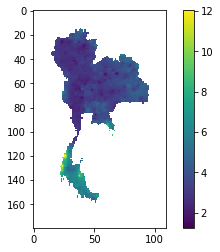

In [ ]:
# Let's look at the generated precipitation grid (our groundtruth)
img = plt.imshow(np.mean(obs_precipitation, axis=0).reshape(180,110), interpolation='nearest')

plt.colorbar(img)
# Note how this grid only has values in Thailand region.

In [ ]:
# check for missing information, fill in 0 for IMERG values
imerg_missing_mask = ~np.isnan(imerg_precipitation)
obs_missing_mask = ~np.isnan(obs_precipitation)

imerg_precipitation[np.isnan(imerg_precipitation)] = 0

In [ ]:
# When we do prediction we will only care about the region of Thailand.
# Thus, we create a mask indicating the region that we care about.
# Create missing mask for calculating the loss only on real values.

missing_mask = np.logical_and(imerg_missing_mask,obs_missing_mask.reshape(-1,180,110))

In [ ]:
#We will apply datetime to all pixel so we need to expand its size
datetime_value = np.apply_along_axis(convert_datetime, 1, imerg_datetime.reshape(-1,1))
circular_datetime_value = np.apply_along_axis(circular_transform, 1, datetime_value.reshape(-1,1))

datetime_array = np.array(expand_size(circular_datetime_value))

In [ ]:
circular_datetime_value[:10]

array([[0.01721336, 0.99985184],
       [0.03442161, 0.9994074 ],
       [0.05161967, 0.99866682],
       [0.06880243, 0.99763031],
       [0.0859648 , 0.99629817],
       [0.1031017 , 0.99467082],
       [0.12020804, 0.99274872],
       [0.13727877, 0.99053245],
       [0.15430882, 0.98802267],
       [0.17129314, 0.98522011]])

In [ ]:
print("Before expand: "+str(circular_datetime_value.shape))
print("After expand: "+str(datetime_array.shape))

Before expand: (1461, 2)
After expand: (1461, 180, 110, 2)


In [ ]:
datetime_array.shape
# The shape of the datetime array is (timestep, long, lat, sin/cos)
# the sin/cos values are repeated to every lat/long value in each time step

(1461, 180, 110, 2)

In [ ]:
daily_imerg_precipitation = imerg_precipitation.reshape(-1,180,110,1)
daily_obs_precipitation = obs_precipitation.reshape(-1,180,110,1)


daily_obs_precipitation[np.isnan(daily_obs_precipitation)] = 0

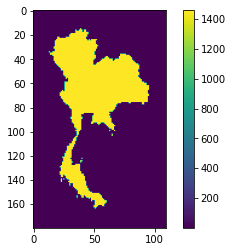

In [ ]:
#Checking region mask
img = plt.imshow(np.sum(missing_mask,axis=0).astype(int))
plt.colorbar(img)

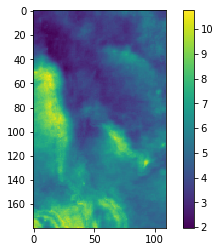

In [ ]:
#Show daily IMERG
img = plt.imshow(np.mean(daily_imerg_precipitation,axis=0).reshape(180,110), interpolation='nearest')

plt.colorbar(img)

In [ ]:
# Our model input is the concatenation of IMERG and circular day of year feature
raw_data = np.concatenate([daily_imerg_precipitation,
                           datetime_array,
                           ],axis=-1)

# Splitting data

In [ ]:
test_begin = convert_datetime(test_begin_date)
test_end = convert_datetime(test_end_date)

train_data_value = []
test_data_value = []

train_missing_mask = []
test_missing_mask = []

train_rainfall_value = []
test_rainfall_value = []

train_date = []

for i in range(len(datetime_value)):
  if test_end >= datetime_value[i] >= test_begin:
    test_data_value.append(raw_data[i])
    test_missing_mask.append(missing_mask[i])
    test_rainfall_value.append(daily_obs_precipitation[i])

  elif test_begin.year >= datetime_value[i].year:
    train_data_value.append(raw_data[i])
    train_missing_mask.append(missing_mask[i])
    train_rainfall_value.append(daily_obs_precipitation[i])
    train_date.append(datetime_value[i])

In [ ]:
train_data_value = np.array(train_data_value)
test_data_value = np.array(test_data_value)

train_missing_mask = np.array(train_missing_mask)
test_missing_mask = np.array(test_missing_mask)

train_rainfall_value = np.array(train_rainfall_value)
test_rainfall_value = np.array(test_rainfall_value)

In [ ]:
# normalize the training data
data_x, rain_obs, diff, rain_imerg_mean, rain_imerg_std, rain_obs_mean, rain_obs_std, diff_mean, diff_std, other_mean, other_std = preprocess(train_data_value, train_rainfall_value)

In [ ]:
mean_std = [rain_imerg_mean, rain_imerg_std, rain_obs_mean, rain_obs_std, diff_mean, diff_std]

In [ ]:
# normalize the val/test data
test_x, test_rain_obs, test_diff = preprocess(test_data_value, test_rainfall_value, lon_lat_mean_std=[other_mean, other_std], mean_std=mean_std, return_mean_std=False)

In [ ]:
val_begin = convert_datetime(val_begin_date)
val_end = convert_datetime(val_end_date)

X_train = []
X_val = []

missing_mask_train = []
missing_mask_val = []

y_train = []
y_val = []

for i in range(len(train_date)):
  if val_end >= train_date[i] >= val_begin:
    X_val.append(data_x[i])
    missing_mask_val.append(train_missing_mask[i])
    y_val.append(diff[i])

  elif val_begin.year >= train_date[i].year:
    X_train.append(data_x[i])
    missing_mask_train.append(train_missing_mask[i])
    y_train.append(diff[i])

In [ ]:
X_train = np.asarray(X_train).astype('float32')
missing_mask_train = np.asarray(missing_mask_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

X_val = np.asarray(X_val).astype('float32')
missing_mask_val = np.asarray(missing_mask_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')

X_test = np.asarray(test_x).astype('float32')
missing_mask_test = np.asarray(test_missing_mask).astype('float32')
y_test = np.asarray(test_diff).astype('float32')

Because our model can handle only input with size of 256*128, we need to pad the data so it can be fed to the model. 

Our original is 180x110 so we pad top and bottom by 38 each, and left and right by 9 each.

In [ ]:
extra_X_train = np.copy(np.pad(X_train, ((0, 0), (38, 38), (9, 9), (0, 0)), mode='constant', constant_values=0))
extra_X_val = np.copy(np.pad(X_val, ((0, 0), (38, 38), (9, 9), (0, 0)), mode='constant', constant_values=0))
extra_X_test = np.copy(np.pad(X_test, ((0, 0), (38, 38), (9, 9), (0, 0)), mode='constant', constant_values=0))

In [ ]:
length_x_train = extra_X_train.shape[0]

In [ ]:
batch_size = 36

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((extra_X_train, missing_mask_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((extra_X_val, missing_mask_val, y_val))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((extra_X_test, missing_mask_test, y_test, test_rain_obs))
test_dataset = test_dataset.batch(batch_size)

## Model

In [ ]:
def down_sample_part(x, dim, filter=3, dropout = 0.1):
  
    x = layers.Conv2D(dim, filter, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    # x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(dim, filter, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Dropout(dropout)(x)
    x = layers.MaxPool2D()(x)

    return x 


In [ ]:
def up_sample_part(x, dim, filter=3, dropout = 0.1):
  
    x = layers.Conv2D(dim, filter, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    # x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(dim, filter, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    # x = layers.Dropout(dropout)(x)

    x = layers.UpSampling2D(2)(x)

    return x 


In [ ]:
def conv_part(x, dim, filter=3, dropout = 0.1):
  
    x = layers.Conv2D(dim, filter, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    # x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(dim, filter, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    # x = layers.Dropout(dropout)(x)

    return x 


In [ ]:
def create_model():

    inputs = keras.Input(shape=(256, 128, 3))
    
    x = down_sample_part(inputs, 32)
    
    x = down_sample_part(x, 64)
    
    x = down_sample_part(x, 128)
    
    x = down_sample_part(x, 256)
    
    x = up_sample_part(x, 512)
    
    x = up_sample_part(x, 256)
    
    x = up_sample_part(x, 128)
    
    x = up_sample_part(x, 64)
    
    x = conv_part(x, 32)
    
    outputs = layers.Conv2D(1, 3, padding="same", dtype='float32')(x)

    model = keras.Model(inputs=inputs, outputs=[outputs])

    return model

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), metrics=["mape", "mse"])

After we run the code from above, we will get the model structure as shown in the image below. Note that the number of convolution layers is not exact.
![](https://drive.google.com/uc?export=view&id=1l6hnG5L97lJKr-VjOUlmMiSI3zw1sing)

# Training

Because some regions of output is not a part of Thailand, we will mask these regions and exclude them from calculating the model loss.

In [ ]:
def mask_mae_loss(y_true,y_pred,mask):

    y_pred = y_pred[:, 38:-38, 9:-9,:] #remove the padded portion

    y_true = tf.squeeze(y_true)
    y_pred = tf.squeeze(y_pred)

    y_true = tf.math.multiply(y_true,mask)
    y_pred = tf.math.multiply(y_pred,mask)

    return tf.keras.losses.mean_absolute_error(y_true,y_pred)

In [ ]:
EPOCHS = 50

name = 'early_mask_grid_conv_rain_May-Oct=2020'

checkpoint_filepath = "/content"+name+'.h5'

In [ ]:
metric_names = ['train_loss','val_loss']
min_val_loss = 1e+5

In [ ]:
train_loss_hist = []
val_loss_hist = []

for epoch in range(EPOCHS):

    # Iterate over the batches of the dataset.
    train_loss = []
    print("Epoch "+str(epoch+1)+"/ "+str(EPOCHS))
    
    pb_i = Progbar(length_x_train, stateful_metrics=metric_names)

    for step, (x_batch_train, mask_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            logits = model(x_batch_train, training=True)

            loss_value = mask_mae_loss(y_batch_train, logits, mask_batch_train)

        train_loss.append(np.mean(loss_value.numpy().tolist()))

        grads = tape.gradient(loss_value, model.trainable_weights)
 
        model.optimizer.apply_gradients(zip(grads, model.trainable_weights))

        values=[('train_loss',loss_value)]

        pb_i.update((step+1)*batch_size, values=values) 

    train_loss_hist.append(np.mean(train_loss))

    val_loss = []
    

    for step, (x_batch_val, mask_batch_val, y_batch_val) in enumerate(val_dataset):

        logits = model(x_batch_val, training=False)

        val_loss_value = mask_mae_loss(y_batch_val, logits, mask_batch_val)

        val_loss.append(np.mean(val_loss_value.numpy().tolist()))

    mean_val_loss = np.mean(val_loss)
    values=[('train_loss',loss_value),('val_loss',mean_val_loss)]
    pb_i.update(length_x_train, values=values, finalize=True)
    val_loss_hist.append(mean_val_loss)
    
    #Save best model weight
    if mean_val_loss == mean_val_loss and mean_val_loss < min_val_loss:
      print("Save weight: loss="+str(mean_val_loss))

      model.save_weights(checkpoint_filepath)
      min_val_loss = mean_val_loss

Epoch 1/ 50
730/730 [==============================] - 43s 58ms/step - train_loss: 0.1045 - val_loss: 0.1083
Save weight: loss=0.10825371633698037
Epoch 2/ 50
730/730 [==============================] - 6s 9ms/step - train_loss: 0.1030 - val_loss: 0.1017
Save weight: loss=0.1016963065810705
Epoch 3/ 50
730/730 [==============================] - 6s 8ms/step - train_loss: 0.1039 - val_loss: 0.0958
Save weight: loss=0.09582264390639819
Epoch 4/ 50
730/730 [==============================] - 6s 8ms/step - train_loss: 0.0694 - val_loss: 0.0963
Epoch 5/ 50
730/730 [==============================] - 7s 9ms/step - train_loss: 0.0650 - val_loss: 0.0982
Epoch 6/ 50
730/730 [==============================] - 6s 8ms/step - train_loss: 0.0636 - val_loss: 0.1065
Epoch 7/ 50
730/730 [==============================] - 6s 9ms/step - train_loss: 0.0630 - val_loss: 0.0945
Save weight: loss=0.09452142719637681
Epoch 8/ 50
730/730 [==============================] - 6s 8ms/step - train_loss: 0.0839 - val_loss

Text(0, 0.5, 'Loss')

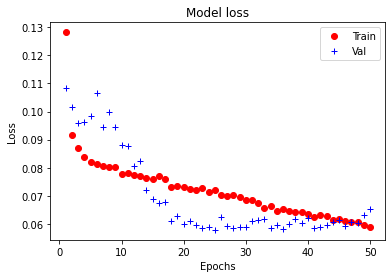

In [ ]:
epochs = range(1, len(train_loss_hist) + 1)

plt.plot(epochs, train_loss_hist, 'ro')
plt.plot(epochs, val_loss_hist, 'b+')
plt.title('Model loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Model evaluation

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
obs_test = []
imerg_test = []
true_diff_test = []
diff_test = []

rain_imerg_mean, rain_imerg_std, rain_obs_mean, rain_obs_std, diff_mean, diff_std = mean_std

for step, (x_batch_test, mask_batch_test, y_batch_test, obs_batch_test) in enumerate(test_dataset):

    logits = model(x_batch_test, training=False)
    
    # Remove padding from imerg
    imerg_batch_test = (x_batch_test[:, 38:-38, 9:-9,-1]*rain_imerg_std)+rain_imerg_mean
    imerg_batch_test = tf.expand_dims(imerg_batch_test, axis=-1)

    obs_batch_test = (obs_batch_test*rain_obs_std)+rain_obs_mean

    # Remove padding from predicition
    diff_batch_test = (logits[:, 38:-38, 9:-9,:]*diff_std)+diff_mean
    true_diff_batch_test = (y_batch_test*diff_std)+diff_mean

    imerg_batch_test = tf.reshape(imerg_batch_test, (-1,1)).numpy()
    obs_batch_test = tf.reshape(obs_batch_test, (-1,1)).numpy()
    diff_batch_test = tf.reshape(diff_batch_test, (-1,1)).numpy()
    true_diff_batch_test = tf.reshape(true_diff_batch_test, (-1,1)).numpy()


    mask_batch_test = tf.reshape(mask_batch_test, (-1,)).numpy() > 0


    imerg_test.extend(imerg_batch_test[mask_batch_test,:].tolist())
    obs_test.extend(obs_batch_test[mask_batch_test,:].tolist())
    diff_test.extend(diff_batch_test[mask_batch_test,:].tolist())
    true_diff_test.extend(true_diff_batch_test[mask_batch_test,:].tolist())

In [ ]:
obs_test = np.array(obs_test, dtype=np.float32)
imerg_test = np.array(imerg_test, dtype=np.float32)
diff_test = np.array(diff_test, dtype=np.float32)
true_diff_test = np.array(true_diff_test, dtype=np.float32)

# Since we predict the difference we add it back to IMERG to get our final prediction
correct = imerg_test-diff_test
correct[correct < 0] = 0

In [ ]:
# The MSE between the observed grid and actual error. This should be zero (ignoring numerical error).
mean_squared_error(obs_test, imerg_test-true_diff_test, squared=False)

7.939828e-07

In [ ]:
# The MSE between the observed grid and our prediction
mean_squared_error(obs_test, correct, squared=False)

10.048673

In [ ]:
# The MSE between the observed grid and IMERG
mean_squared_error(obs_test, imerg_test, squared=False)

12.422995

## Visualizations

Let's look qualitatively how our model performs.

In [ ]:
del obs_test, imerg_test, true_diff_test, diff_test, correct

In [ ]:
obs_test = []
imerg_test = []
mask_test = []
diff_test = []
true_diff_test = []

rain_imerg_mean, rain_imerg_std, rain_obs_mean, rain_obs_std, diff_mean, diff_std = mean_std

for step, (x_batch_test, mask_batch_test, y_batch_test, obs_batch_test) in enumerate(test_dataset):

    logits = model(x_batch_test, training=False)

    
    # Remove padding from imerg
    imerg_batch_test = (x_batch_test[:, 38:-38, 9:-9,-1]*rain_imerg_std)+rain_imerg_mean
    imerg_batch_test = tf.expand_dims(imerg_batch_test, axis=-1)

    obs_batch_test = (obs_batch_test*rain_obs_std)+rain_obs_mean

    
    # Remove padding from predicition
    diff_batch_test = (logits[:, 38:-38, 9:-9,:]*diff_std)+diff_mean
    true_diff_batch_test = (y_batch_test*diff_std)+diff_mean

    mask_batch_test = mask_batch_test.numpy() > 0
    
    imerg_test.extend(imerg_batch_test.numpy().tolist())
    obs_test.extend(obs_batch_test.numpy().tolist())
    diff_test.extend(diff_batch_test.numpy().tolist())
    mask_test.extend(mask_batch_test.tolist())
    true_diff_test.extend(true_diff_batch_test.numpy().tolist())

In [ ]:
obs_test = np.array(obs_test, dtype=np.float32)[:,:,:,0]
imerg_test = np.array(imerg_test, dtype=np.float32)[:,:,:,0]
mask_test = np.array(mask_test)
diff_test = np.array(diff_test, dtype=np.float32)[:,:,:,0]
true_diff_test = np.array(true_diff_test, dtype=np.float32)[:,:,:,0]

In [ ]:
correct = imerg_test-diff_test
correct[correct < 0] = 0

In [ ]:
# Fill other pixels that are not in Thailand with NaN

correct[~mask_test] = np.nan
imerg_test[~mask_test] = np.nan
obs_test[~mask_test] = np.nan

### Visualize our predicted precipitation grid

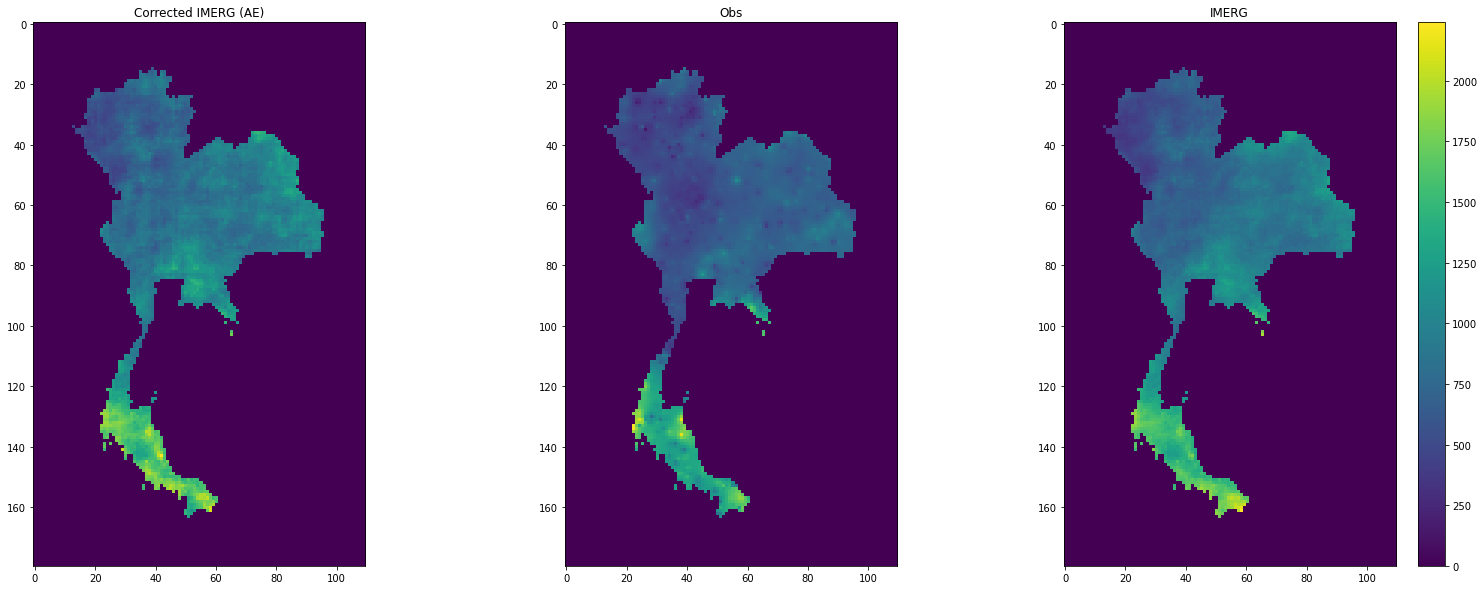

In [ ]:
# viewing average rainfall
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(27, 10))

current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='white')

img = axes[0].imshow(np.nansum(correct, axis=0), interpolation='nearest')
axes[0].title.set_text('Corrected IMERG (AE)')

axes[1].imshow(np.nansum(obs_test, axis=0), interpolation='nearest')
axes[1].title.set_text('Obs')

axes[2].imshow(np.nansum(imerg_test, axis=0), interpolation='nearest')
axes[2].title.set_text('IMERG')


fig.colorbar(img)

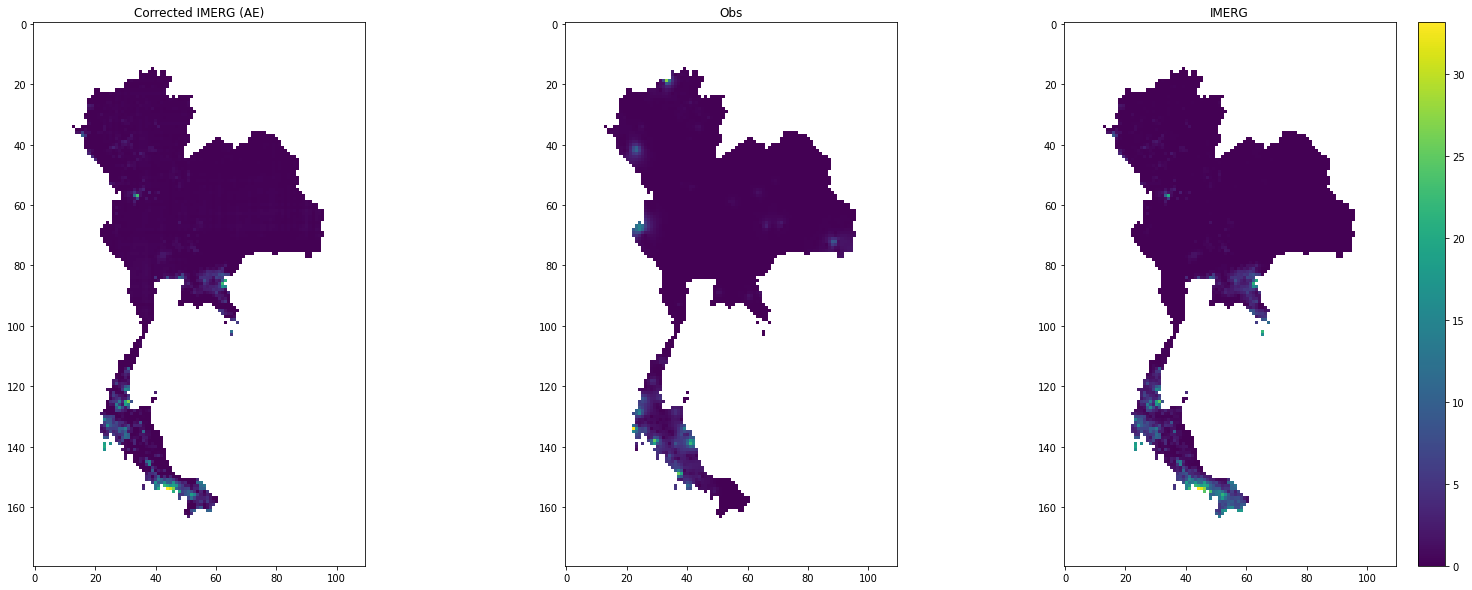

In [ ]:
# viewing one day
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(27, 10))

current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='white')

img = axes[0].imshow(correct[309,:,:], interpolation='nearest')
axes[0].title.set_text('Corrected IMERG (AE)')

axes[1].imshow(obs_test[309,:,:], interpolation='nearest')
axes[1].title.set_text('Obs')

axes[2].imshow(imerg_test[309,:,:], interpolation='nearest')
axes[2].title.set_text('IMERG')


fig.colorbar(img)

### Visualize precipitation as time series

In [ ]:
#Pick one station pixel
point = [85, 61] 

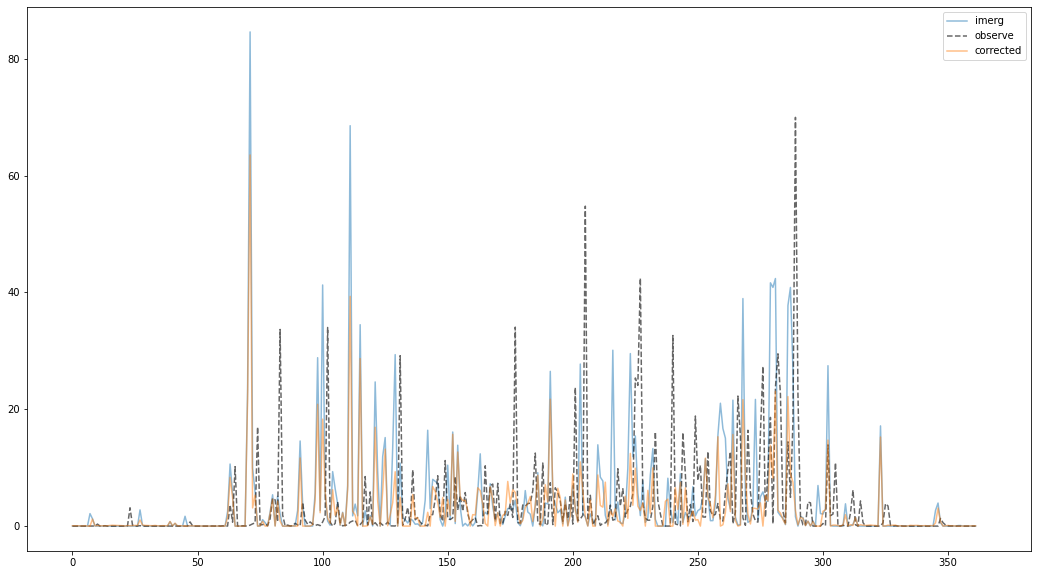

In [ ]:
point_imerg = imerg_test[:, point[0], point[1]]
point_obs = obs_test[:, point[0], point[1]]
point_correct = correct[:, point[0], point[1]]

plt.figure(figsize=(18,10))
plt.plot(point_imerg, label="imerg", alpha=0.5)
plt.plot(point_obs, label="observe", alpha=0.6, c="black", ls="--")
plt.plot(point_correct, label="corrected", alpha=0.5)


plt.legend()